In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

In [3]:
with ZipFile("archive.zip","r") as zip:
    zip.extractall()

In [4]:
batch_size = 32
img_size = (256,256)

In [5]:
train_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 1337,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 1337,
    shuffle = True,
    image_size = img_size,
    batch_size = batch_size,
)

from tensorflow.data.experimental import cardinality

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names
print(class_names)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.
['Normal', 'Tuberculosis']


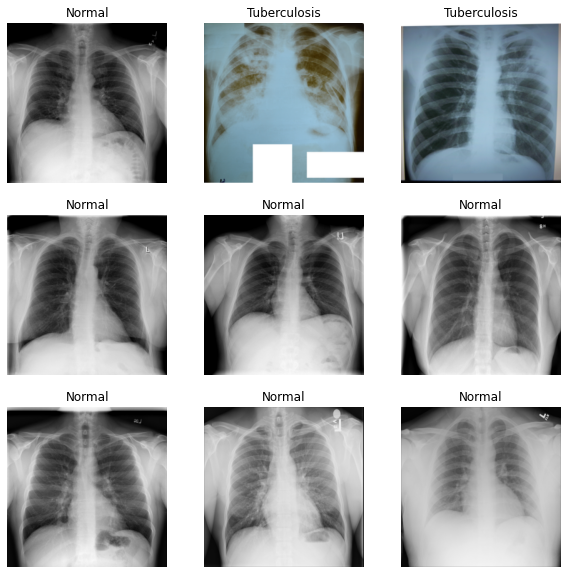

In [6]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

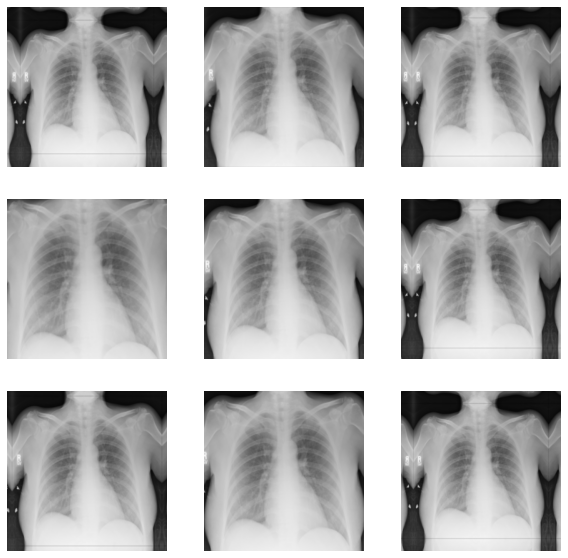

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

data_augmentation = Sequential([
    RandomZoom(0.2),
])

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Define the model

In [8]:
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Input, Model

preprocess_input = efficientnet.preprocess_input

IMG_SHAPE = img_size+(3,)
base_model = EfficientNetB3(input_shape=IMG_SHAPE,include_top=False,weights="imagenet")
image_batch,label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()
feature_batch_average = GlobalAveragePooling2D()(feature_batch)

prediction_layer = Dense(2,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)

class Transfer_Efficient():
    def model(self,y):
        self.x = data_augmentation(y)
        self.x = preprocess_input(self.x)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dropout(0.2,seed=1337)(self.x)
        self.outputs = prediction_layer(self.x)
        self.model = Model(y,self.outputs)
        return self.model

m = Transfer_Efficient()
model = m.model(Input(shape=IMG_SHAPE))
model.summary()
model.compile(Adam(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 8, 8, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 10,786,609
Trainable params: 3,074
Non-trainable params: 10,783,535
_____________________________________________

### Train and test the accuracy of the model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    loss0,accuracy0 = model.evaluate(val_ds)
    print("Initial loss: {:.2f} %".format(100*loss0))
    print("Initial accuracy: {:.2f} %".format(100*accuracy0))
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_loss",save_best_only=True)
    model.fit(train_ds,epochs=6,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    loss,accuracy = best.evaluate(test_ds)
    print("\nTest accuracy: {:.2f}".format(100*accuracy))
    print("Test loss: {:.2f} %".format(100*loss))

22/22 [==============================] - 11s 319ms/step - loss: 0.5525 - accuracy: 0.7868
Initial loss: 55.25 %
Initial accuracy: 78.68 %
Epoch 1/6
105/105 [==============================] - 42s 355ms/step - loss: 0.2064 - accuracy: 0.9190 - val_loss: 0.1205 - val_accuracy: 0.9456


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/6
105/105 [==============================] - 37s 347ms/step - loss: 0.1086 - accuracy: 0.9661 - val_loss: 0.0778 - val_accuracy: 0.9691
Epoch 3/6
105/105 [==============================] - 36s 338ms/step - loss: 0.0849 - accuracy: 0.9729 - val_loss: 0.0860 - val_accuracy: 0.9618
Epoch 4/6
105/105 [==============================] - 36s 340ms/step - loss: 0.0729 - accuracy: 0.9759 - val_loss: 0.0640 - val_accuracy: 0.9765
Epoch 5/6
105/105 [==============================] - 36s 341ms/step - loss: 0.0645 - accuracy: 0.9827 - val_loss: 0.0663 - val_accuracy: 0.9765
Epoch 6/6
5/5 [==============================] - 3s 271ms/step - loss: 0.0677 - accuracy: 0.9812

Test accuracy: 98.12
Test loss: 6.77 %
